# Clustering for dataset exploration

Learn how to discover the underlying groups (or "clusters") in a dataset. By the end of this chapter, you'll be clustering companies using their stock market prices, and distinguishing different species by clustering their measurements.

## Supervised vs unsupervised learning
● Supervised learning finds pa!erns for a prediction task<br>
● E.g. classify tumors as benign or cancerous (labels)<br>
● Unsupervised learning finds pa!erns in data but without a specific prediction task in mind<br>

### k-means clustering
● Finds clusters of samples<br>
● Number of clusters must be specified<br>

### Cluster labels for new samples
● New samples can be assigned to existing clusters<br>
● k-means remembers the mean of each cluster (the "centroids")<br>
● Finds the nearest centroid to each new sample<br>

In [31]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [53]:
#load dataset as array
seeds = pd.read_csv('./datasets/grains/seeds.csv', header=None)
seeds[7] = seeds[7].map({1:'Kama wheat', 2:'Rosa wheat', 3:'Canadian wheat'})
seeds.head()

,0,1,2,3,4,5,6,7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,Kama wheat
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,Kama wheat
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,Kama wheat
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,Kama wheat
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,Kama wheat


In [27]:
#Create arrays from the dataframe
samples = seeds.loc[:,0:6].values
varieties = seeds.loc[:,7]

## Evaluating a clustering
● Measure quality of a clustering<br>
  &emsp;  ● Using only samples and their cluster labels<br>
  &emsp;  ● A good clustering has tight clusters and samples in each cluster bunched together<br>
● Informs choice of how many clusters to look for<br>

### Inertia measures clustering quality
● Measures how spread out the clusters are (lower is better)<br>
● Distance from each sample to centroid of its cluster<br>
● After fit(), available as attribute inertia_<br>
● k-means attempts to minimize the inertia when choosing clusters<br>
● Choose an "elbow" in the inertia plot<br>
● Where inertia begins to decrease more slowly<br>

### How many clusters of grain?
What's a good number of clusters in this case?<br>


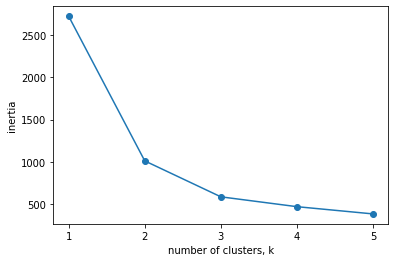

In [28]:
ks = range(1, 6)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(samples)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


### Evaluating the grain clustering
From the inertia plot,3 is a good number of clusters for the grain data. In fact, the grain samples come from a mix of 3 different grain varieties: "Kama", "Rosa" and "Canadian". In this exercise, cluster the grain samples into three clusters, and compare the clusters to the grain varieties using a cross-tabulation.

In [14]:
#varieties list
# Create a KMeans model with 3 clusters: model
model = KMeans(n_clusters=3)

# Use fit_predict to fit model and obtain cluster labels: labels 
### Using .fit_predict() is the same as using .fit() followed by .predict()
labels = model.fit_predict(samples)

# Create a DataFrame with labels and varieties as columns: df
df = pd.DataFrame({'labels': labels, 'varieties': varieties})

# Create crosstab: ct
ct = pd.crosstab(df['labels'], df['varieties'])

# Display ct
print(ct)


varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
0                       2          60          10
1                       0           1          60
2                      68           9           0


### Scaling fish data for clustering
You are given an array samples giving measurements of fish. Each row represents an individual fish. The measurements, such as weight in grams, length in centimeters, and the percentage ratio of height to length, have very different scales. In order to cluster this data effectively, you'll need to standardize these features first. In this exercise, you'll build a pipeline to standardize and cluster the data.

In [54]:
#load dataset
fish = pd.read_csv('./datasets/fish.csv', header=None)
fish.head()

,0,1,2,3,4,5,6
0,Bream,242.0,23.2,25.4,30.0,38.4,13.4
1,Bream,290.0,24.0,26.3,31.2,40.0,13.8
2,Bream,340.0,23.9,26.5,31.1,39.8,15.1
3,Bream,363.0,26.3,29.0,33.5,38.0,13.3
4,Bream,430.0,26.5,29.0,34.0,36.6,15.1


In [22]:
#create arrays
f_samples = fish.loc[:,1:6].values
species = fish.loc[:, 0].values

In [23]:
#instantiate
# scaler: scaler
scaler = StandardScaler()

# KMeans instance: kmeans
kmeans = KMeans(n_clusters=4)

#pipeline: pipeline
pipeline = make_pipeline(scaler, kmeans)


### Clustering the fish data
You'll now use your standardization and clustering pipeline from the previous exercise to cluster the fish by their measurements, and then create a cross-tabulation to compare the cluster labels with the fish species.

In [30]:
#Fit the pipeline to the fish measurements samples.
pipeline.fit(f_samples)
#Obtain the cluster labels for samples by using the .predict() method of pipeline.
labels = pipeline.predict(f_samples)
#Using pd.DataFrame(), create a DataFrame df with two columns named 'labels' and 
   #'species', using labels and species, respectively, for the column values.
df = pd.DataFrame({'labels':labels, 'species': species})
#Using pd.crosstab(), create a cross-tabulation ct of df['labels'] and df['species'].
ct = pd.crosstab(df['labels'], df['species'])

ct

species,Bream,Pike,Roach,Smelt
labels,,,,
0,33,0,1,0
1,1,0,19,1
2,0,17,0,0
3,0,0,0,13


### Clustering stocks using KMeans
In this exercise, you'll cluster companies using their daily stock price movements (i.e. the dollar difference between the closing and opening prices for each trading day). You are given a NumPy array movements of daily price movements from 2010 to 2015 (obtained from Yahoo! Finance), where each row corresponds to a company, and each column corresponds to a trading day.

Some stocks are more expensive than others. To account for this, include a Normalizer at the beginning of your pipeline. The Normalizer will separately transform each company's stock price to a relative scale before the clustering begins.

Note that Normalizer() is different to StandardScaler(), which you used in the previous exercise. While StandardScaler() standardizes features (such as the features of the fish data from the previous exercise) by removing the mean and scaling to unit variance, Normalizer() rescales each sample - here, each company's stock price - independently of the other.

In [55]:
#load dataset
stock = pd.read_csv('./datasets/company-stock-movements-2010-2015-incl.csv' )
stock.head()

,Unnamed: 0,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,...,2013-10-16,2013-10-17,2013-10-18,2013-10-21,2013-10-22,2013-10-23,2013-10-24,2013-10-25,2013-10-28,2013-10-29
0,Apple,0.580000,-0.220005,-3.409998,-1.170000,1.680011,-2.689994,-1.469994,2.779997,-0.680003,...,0.320008,4.519997,2.899987,9.590019,-6.540016,5.959976,6.910011,-5.359962,0.840019,-19.589981
1,AIG,-0.640002,-0.650000,-0.210001,-0.420000,0.710001,-0.200001,-1.130001,0.069999,-0.119999,...,0.919998,0.709999,0.119999,-0.480000,0.010002,-0.279998,-0.190003,-0.040001,-0.400002,0.660000
2,Amazon,-2.350006,1.260009,-2.350006,-2.009995,2.960006,-2.309997,-1.640007,1.209999,-1.790001,...,2.109985,3.699982,9.570008,-3.450013,4.820008,-4.079986,2.579986,4.790009,-1.760009,3.740021
3,American express,0.109997,0.000000,0.260002,0.720002,0.190003,-0.270001,0.750000,0.300004,0.639999,...,0.680001,2.290001,0.409996,-0.069999,0.100006,0.069999,0.130005,1.849999,0.040001,0.540001
4,Boeing,0.459999,1.770000,1.549999,2.690003,0.059997,-1.080002,0.360000,0.549999,0.530002,...,1.559997,2.480003,0.019997,-1.220001,0.480003,3.020004,-0.029999,1.940002,1.130005,0.309998


In [52]:
# create movement array
movements = stock.iloc[:,1:].values
print(movements[:5])
companies = stock.iloc[:, 0].values
companies[:5]

[[  0.58      -0.220005  -3.409998 ...  -5.359962   0.840019 -19.589981]
 [ -0.640002  -0.65      -0.210001 ...  -0.040001  -0.400002   0.66    ]
 [ -2.350006   1.260009  -2.350006 ...   4.790009  -1.760009   3.740021]
 [  0.109997   0.         0.260002 ...   1.849999   0.040001   0.540001]
 [  0.459999   1.77       1.549999 ...   1.940002   1.130005   0.309998]]


array(['Apple', 'AIG', 'Amazon', 'American express', 'Boeing'],
      dtype=object)

In [42]:
#Create an instance of Normalizer called normalizer.
normalizer = Normalizer()

#Create an instance of KMeans called kmeans with 10 clusters.
kmeans = KMeans(n_clusters=10)

#Using make_pipeline(), create a pipeline called pipeline that chains normalizer and kmeans.
pipeline = make_pipeline(normalizer, kmeans)

#Fit the pipeline to the movements array.
pipeline.fit(movements)

Pipeline(steps=[('normalizer', Normalizer()),
                ('kmeans', KMeans(n_clusters=10))])

### Which stocks move together?
In the previous exercise, you clustered companies by their daily stock price movements. So which company have stock prices that tend to change in the same way? You'll now inspect the cluster labels from your clustering to find out.

In [43]:
#Use the .predict() method of the pipeline to predict the labels for movements.
labels =pipeline.predict(movements)
# Create a DataFrame aligning labels and companies: df
df = pd.DataFrame({'labels': labels, 'companies': companies})

#Use the .sort_values() method of df to sort the DataFrame by the 'labels' column, and print the result.
print(df.sort_values(by='labels'))

    labels                           companies
0        0                               Apple
47       0                            Symantec
43       0                                 SAP
30       0                          MasterCard
17       0                     Google/Alphabet
59       0                               Yahoo
2        0                              Amazon
26       1                      JPMorgan Chase
55       1                         Wells Fargo
5        1                     Bank of America
1        1                                 AIG
18       1                       Goldman Sachs
56       2                            Wal-Mart
9        2                   Colgate-Palmolive
25       2                   Johnson & Johnson
40       2                      Procter Gamble
27       2                      Kimberly-Clark
37       3                            Novartis
39       3                              Pfizer
42       3                   Royal Dutch Shell
6        3   